# Definimos el modelo epidemiológico

In [31]:
!pip install lmfit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
from numpy import arange,array,dot,asarray,zeros,apply_along_axis,around,sort,shape,random,exp,empty,mean,ndarray
from scipy import integrate
from matplotlib.pyplot import plot,figure,title,legend,xlabel,ylabel,grid,axvline,savefig,hist,subplots,subplot
from scipy.stats.mstats import mquantiles
from math import sqrt,log
import pandas as pd
from datetime import datetime,timedelta
from lmfit import minimize,Parameters,Parameter,report_fit
from scipy.stats import poisson,truncnorm
import scipy
import numpy as np
from lmfit import minimize,Parameters,Parameter,report_fit
from statsmodels.graphics.tsaplots import plot_acf

In [33]:
# Modelo en términos de ODEs
def ode_SID(INP,t,alpha,beta,gamma,mu1,mu2,nu,delta):  
    Y = np.zeros((4))
    V = INP    
    Y[0] =alpha*(V[0]+V[1]) - beta * V[0] * V[2] -gamma*V[0]*V[1]-mu1*V[0]
    Y[1] = beta * V[0] * V[2]+gamma*V[0]*V[1] - mu2 * V[1] -nu* V[1]
    Y[2] =nu * V[1] - delta* V[2]
    Y[3]= beta * V[0] * V[2]+gamma*V[0]*V[1]

    return Y  

In [34]:
import scipy.integrate as spi
import numpy as np
import pylab as pl
import scipy.optimize as optimize
pl.style.use('fivethirtyeight')

In [5]:
# Especificamos parámetros y condiciones iniciales
alpha =0.02
beta = 0.015
gamma=0.001
mu1 = 0.02
mu2=0.002
nu=0.081
delta=7/365

N=12350
I0 = 0.0
D0=1.0
S0 = N-I0
INPUT = (S0, I0, D0,0.)

t_start = 0.0; 
t_end = 1.5; 
t_inc = 1/365
t_range = np.arange(t_start, t_end+t_inc, t_inc)



In [628]:
#Función para calcular el número básico de reproducción 
def NumBasR(beta,mu1,nu,delta,N):
  R_0=(nu*beta*N*delta)/(mu1+nu)
  return R_0

NumBasR(beta,mu1,nu,delta,N)

2.8492269089922684

In [6]:
#Calcular la incidencia 
def incidencia(Y_p,period):
  #Número de días
  n=len(Y_p)
  #Número de semanas
  m=int(n/period)
  Y_inc=zeros((m))
  Y_inc[0]=Y_p[period-1]
  for i in range(1,m):
      dif=Y_p[period*(i+1)-1]-Y_p[period*i]
      #if dif>0:
      Y_inc[i]=dif
  return Y_inc

# Usando Odeint

In [7]:
# Resolvemos usando odeint de scipy
SOL = spi.odeint(ode_SID,INPUT,t_range,args=(alpha,beta,gamma,mu1,mu2,nu,delta))

In [8]:
n_days=365*1.5
inc_sem=incidencia(SOL[:,3],7)
#Número de semanas completas en el periodo
n_sem=int(n_days/7)
print(inc_sem)
#Establecer una semilla
random.seed(seed=2022)

#Agregar ruido Poisson porque son datos discretos 
data_sem=poisson.rvs(mu=inc_sem,size=n_sem)


[  3.37745513   4.29523143   5.48154587   7.01382277   8.99136367
  11.54122716  14.82547921  19.0500027   24.47495407  31.42677455
  40.31129554  51.62682816  65.97507415  84.06601886 106.71059867
 134.79174747 169.20085644 210.72387306 259.86151157 316.57601992
 379.97762387 448.00213141 517.18212298 582.66076201 638.59584126
 679.01305239 698.98167063 695.77694422 669.59952054 623.54932386
 562.85979535 493.70485846 422.01301809 352.62302736 288.90203609
 232.76001975 184.90578089 145.19199605 112.94474979  87.22648753
  67.02032237  51.34476433  39.31565543  30.17217545  23.28063442
  18.12593603  14.29724118  11.47182117   9.39934914   7.88774848
   6.79102704   5.99916834   5.42991232   5.02220411   4.7310415
   4.52347533   4.37553676   4.2698989    4.19411307   4.13928912
   4.09911567   4.069138     4.04622968   4.02820869   4.01356033
   4.00123856   3.99052452   3.98092655   3.97210963   3.96384629
   3.95598248   3.94841396   3.94107013   3.93390305   3.92687994
   3.919978

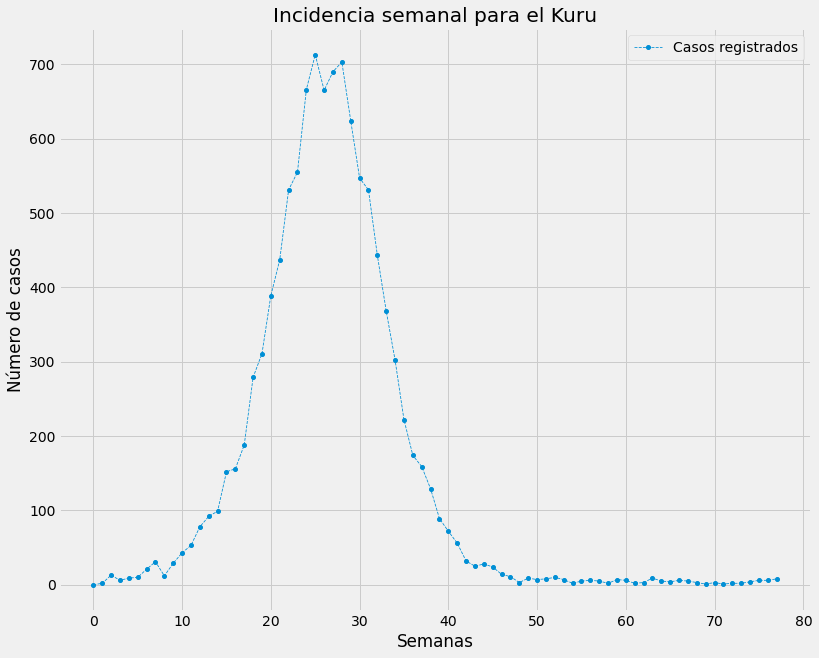

In [9]:
t_sem=arange(0,n_sem,1)
pl.figure(figsize=(12,10))
pl.plot(t_sem,data_sem,linestyle="--",marker="o",markersize=4,linewidth=0.8,label="Casos registrados")
pl.ylabel("Número de casos")
pl.xlabel("Semanas")
pl.legend()
pl.title("Incidencia semanal para el Kuru")
pl.show()

In [10]:
def residual_SID(params,x0_s,ts,datos,periodo):
    alpha,beta,gamma,mu1,mu2,nu,delta=params['alpha'].value,params['beta'].value,params['gamma'].value,params['mu1'].value,params['mu2'].value,params['nu'].value,params['delta'].value
    modelo=integrate.odeint(ode_SID,x0_s,ts,args=(alpha,beta,gamma,mu1,mu2,nu,delta,))
    aprox_dia=modelo[:,3]
    aprox_sem=incidencia(aprox_dia,periodo)
    return ((aprox_sem-datos)**2).ravel()



In [11]:
#Posibles rangos para los parámetros
params=Parameters()

params.add('alpha',value=0.03,min=0,max=0.5)
params.add('beta',value=0.0015,min=0,max=0.5)
params.add('gamma',value=0.01,min=0,max=0.5)
params.add('mu1',value=0.01,min=0,max=0.5)
params.add('mu2',value=0.001,min=0,max=0.5)
params.add('nu',value=0.07,min=0,max=0.5)
params.add('delta',value=0.02,min=0,max=0.5)

#Ajustar el modelo y estimar los parámetros usando por Levenberg-Marquard
#Se utilizará incidencia semanal
periodo=7
estimacion1=minimize(residual_SID,params,args=(INPUT,t_range,data_sem,periodo),method='leastsq')
estimacion1

Las estimaciones encontradas de los parámetro son: Parameters([('alpha', <Parameter 'alpha', value=2.7755575615628914e-17, bounds=[0:0.5]>), ('beta', <Parameter 'beta', value=0.003924198051758698, bounds=[0:0.5]>), ('gamma', <Parameter 'gamma', value=0.0017089532951783948, bounds=[0:0.5]>), ('mu1', <Parameter 'mu1', value=0.5, bounds=[0:0.5]>), ('mu2', <Parameter 'mu2', value=0.4999999999999971, bounds=[0:0.5]>), ('nu', <Parameter 'nu', value=1.142419492339286e-13, bounds=[0:0.5]>), ('delta', <Parameter 'delta', value=0.4790868774289454, bounds=[0:0.5]>)])


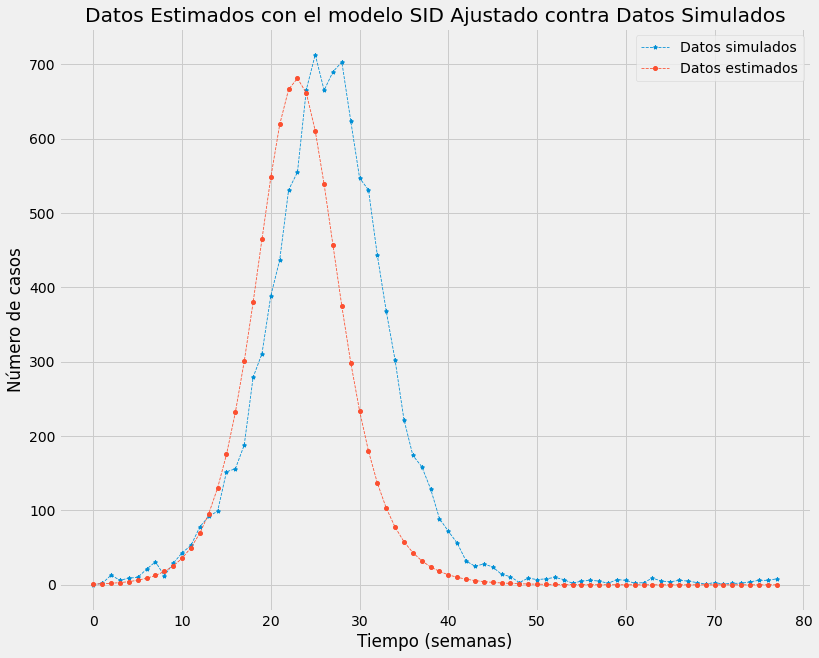

In [12]:
#Extraer parámetros estimados
param_est1=estimacion1.params
print("Las estimaciones encontradas de los parámetro son:",param_est1)

#Obtener la solución del modelo con los parámetros estimados por Levenberg-Marquard
alpha_est1,beta_est1,gamma_est1,mu1_est1,mu2_est1,nu_est1,delta_est1=param_est1['alpha'].value,param_est1['beta'].value,param_est1['gamma'].value,param_est1['mu1'].value,param_est1['mu2'].value,param_est1['nu'].value,param_est1['delta'].value   
result2=integrate.odeint(ode_SID,INPUT,t_range,args=(alpha_est1,beta_est1,gamma_est1,mu1_est1,mu2_est1,nu_est1,delta_est1,))
Y_acum2=result2[:,3]
#Incidencia semanal del modelo ajustado
Y_sem1=incidencia(Y_acum2,7)
#Graficar el modelo obtenido con los datos estimados contra los datos simulados
pl.figure(figsize=(12,10))
pl.plot(t_sem,data_sem,linestyle="--",marker="*",markersize=4,linewidth=0.8,label="Datos simulados")
pl.plot(t_sem,Y_sem1,linestyle="--",marker="o",markersize=4,linewidth=0.8,label="Datos estimados")
pl.ylabel("Número de casos")
pl.xlabel("Tiempo (semanas)")
pl.legend()
pl.title("Datos Estimados con el modelo SID Ajustado contra Datos Simulados")
pl.show()


In [13]:
alpha_est1,beta_est1,gamma_est1,mu1_est1,mu2_est1,nu_est1,delta_est1


(2.7755575615628914e-17,
 0.003924198051758698,
 0.0017089532951783948,
 0.5,
 0.4999999999999971,
 1.142419492339286e-13,
 0.4790868774289454)

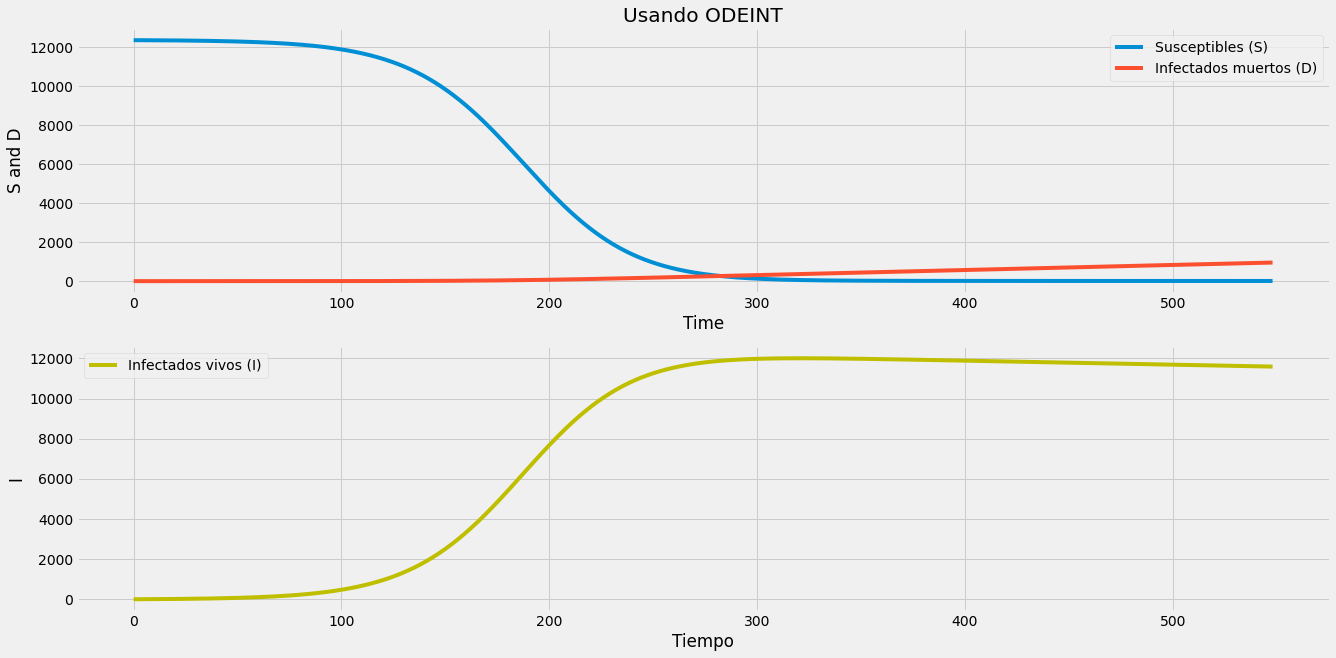

In [14]:
pl.figure(figsize=(20, 10))
pl.subplot(211)
pl.plot(SOL[:,0],  label='Susceptibles (S)')
pl.plot(SOL[:,2],  label='Infectados muertos (D)')
pl.legend(loc=0)
pl.title('Usando ODEINT')
pl.xlabel('Time')
pl.ylabel('S and D')
pl.subplot(212)
pl.plot(SOL[:,1], '-y' ,label='Infectados vivos (I)')
pl.legend(loc=0)
pl.xlabel('Tiempo')
pl.ylabel('I')
pl.show()

Graficamos en una sola gráfica

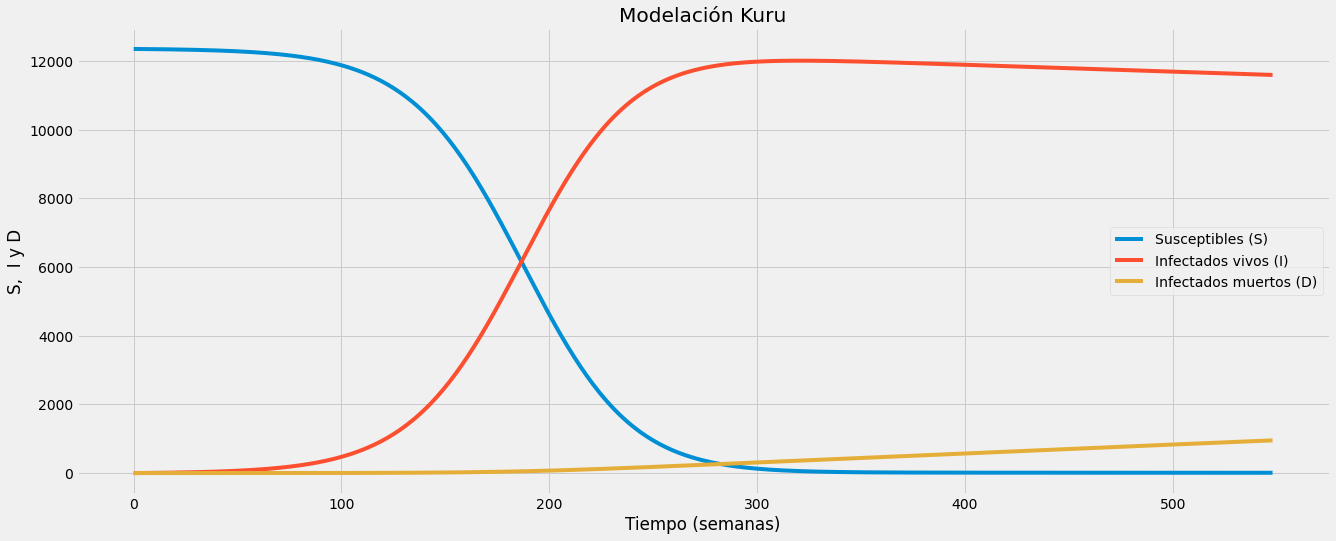

In [ ]:
pl.figure(figsize=(20, 8))
pl.plot(SOL[:,0],  label='Susceptibles (S)') #S
pl.plot(SOL[:,1],  label='Infectados vivos (I)')# I
pl.plot(SOL[:,2],  label='Infectados muertos (D)') # D
pl.title('Modelación Kuru')
pl.xlabel('Tiempo (semanas)')
pl.ylabel('S,  I y D')
pl.legend(loc=0)
pl.show()


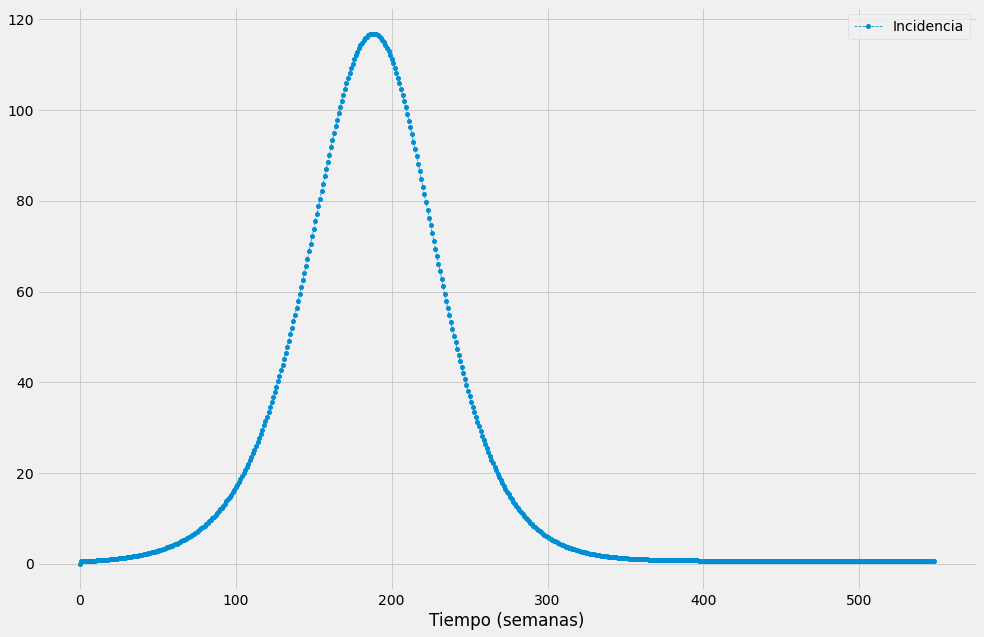

In [638]:
pl.figure(figsize=(15, 10))
inc=np.concatenate((np.array([I0]),np.diff(SOL[:,3])))
#inc11=np.concatenate((np.array([I0]),np.diff(SOL[:,1])))
pl.plot(inc,linestyle="--",marker="o",markersize=4,linewidth=0.8,label='Incidencia')
#pl.plot(inc11,'-c',linestyle="--",marker="o",markersize=4,linewidth=1,label='Incidencia1')
#pl.plot(SOL[:,2])
pl.xlabel('Tiempo (semanas)')
pl.ylabel('')
pl.legend(loc=0)
pl.show()

Incidencia con ruido Normal 

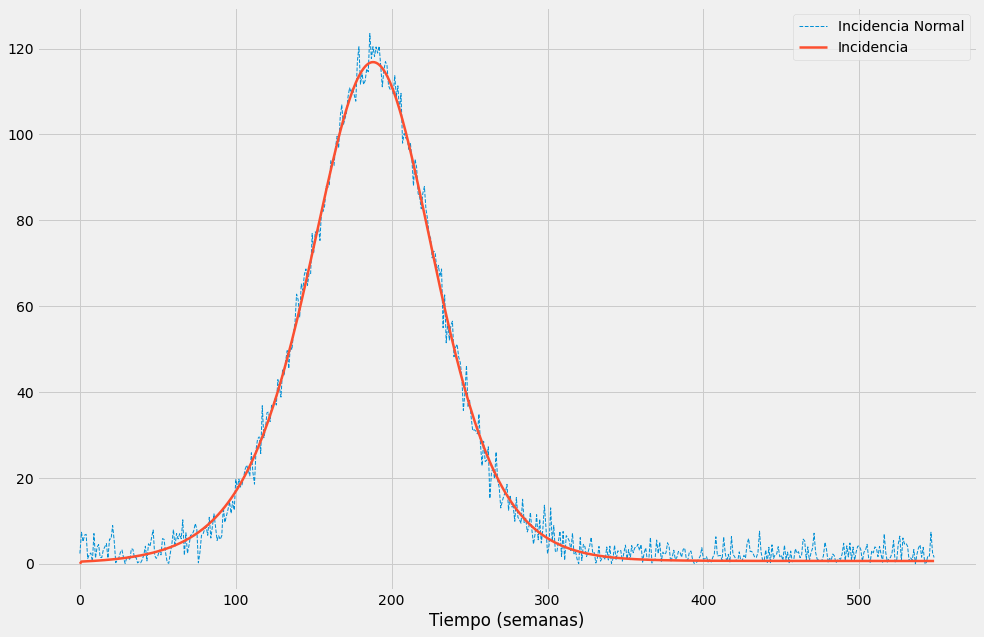

In [ ]:
incNor=inc + np.random.normal(size=inc.shape,scale=3)
incNor=abs(incNor)
pl.figure(figsize=(15, 10))
pl.plot(incNor,linestyle="--",markersize=4,label='Incidencia Normal',linewidth=1)
pl.plot(inc,label='Incidencia', linewidth=2.5)
#pl.plot(SOL[:,2])
pl.xlabel('Tiempo (semanas)')
pl.ylabel('')
pl.legend(loc=0)
pl.show()


Incidencia ajustada

In [ ]:
SOL1= spi.odeint(ode_SID,INPUT,t_range,args=(2.7755575615628914e-17,
 0.003790686678520311,
 0.0017125595450145359,
 0.5,
 0.4999999999999986,
 3.328265441027156e-11,
 0.47190615273592107))

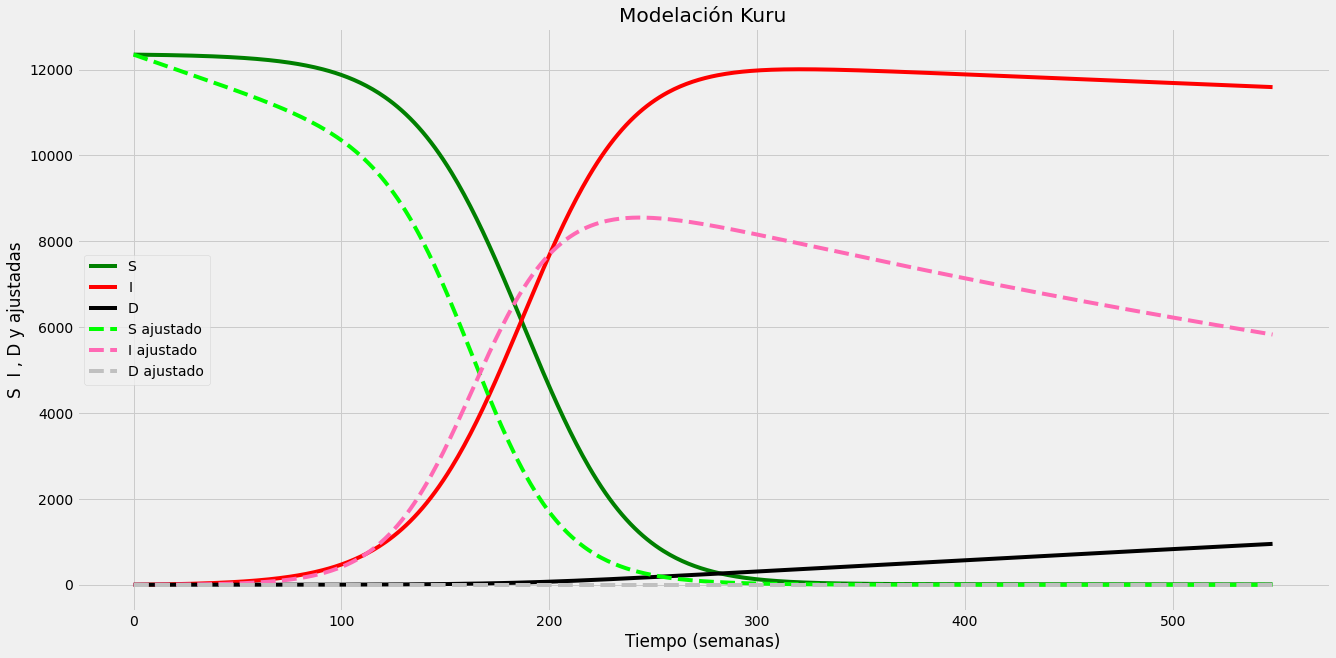

In [ ]:
pl.figure(figsize=(20, 10))
pl.plot(SOL[:,0], '-g', label='S ') #S
pl.plot(SOL[:,1], '-r', label='I')# I
pl.plot(SOL[:,2], '-k', label='D ') # D
pl.plot(SOL1[:,0], '--',color='lime', label='S ajustado') #S
pl.plot(SOL1[:,1], '--', color='hotpink',label='I ajustado')# I
pl.plot(SOL1[:,2], '--',color='silver', label='D ajustado') # D
pl.title('Modelación Kuru')
pl.xlabel('Tiempo (semanas)')
pl.ylabel('S  I , D y ajustadas')
pl.legend(loc=0)
pl.show()

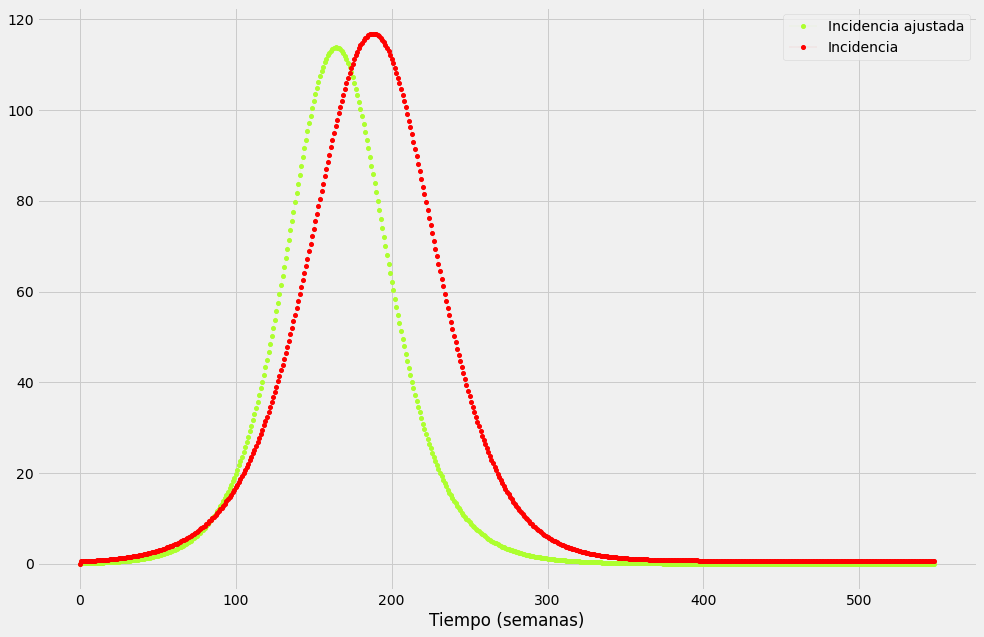

In [ ]:
pl.figure(figsize=(15, 10))
incad=np.concatenate((np.array([I0]),np.diff(SOL1[:,3])))
pl.plot(incad,linestyle="--",marker="o",markersize=4,color='greenyellow',linewidth=0.1,label='Incidencia ajustada')
pl.plot(inc,linestyle="--",marker="o",markersize=4,color='red',linewidth=0.1,label='Incidencia')
#pl.plot(SOL[:,2])
pl.xlabel('Tiempo (semanas)')
pl.legend(loc=0)
pl.show()

#Análisis Bayesiano

In [15]:
par1=[2.5,0,1.1]  #hiperpar'ametros para alpha
par2=[5,0,0.3]  #hiperpar'ametros para beta
par3=[1.2,0,0.5]  #hiperpar'ametros para gamma
par4=[1.1,0,0.3] #hiperparámetros para mu1
par5=[1,0,0.2] #hiperparámetros para mu2
par6=[0.5,0,0.1] #hiperparámetros para nu
par7=[1,0,0.25] #hiperparámetros para delta

def logaprioris(theta):
    alpha,beta,gamma,mu1,mu2,nu,delta = theta
    dalpha = scipy.stats.gamma.logpdf(alpha,par1[0],par1[1],par1[2])
    dbeta = scipy.stats.gamma.logpdf(beta,par2[0],par2[1],par2[2])
    dgamma = scipy.stats.gamma.logpdf(gamma,par3[0],par3[1],par3[2])
    dmu1 = scipy.stats.gamma.logpdf(mu1,par4[0],par4[1],par4[2])
    dmu2 = scipy.stats.gamma.logpdf(mu2,par5[0],par5[1],par5[2])
    dnu = scipy.stats.gamma.logpdf(nu,par6[0],par6[1],par6[2])
    ddelta = scipy.stats.gamma.logpdf(delta,par7[0],par7[1],par7[2])
    return(float(dalpha+dbeta+dgamma+dmu1+dmu2+dnu+ddelta))

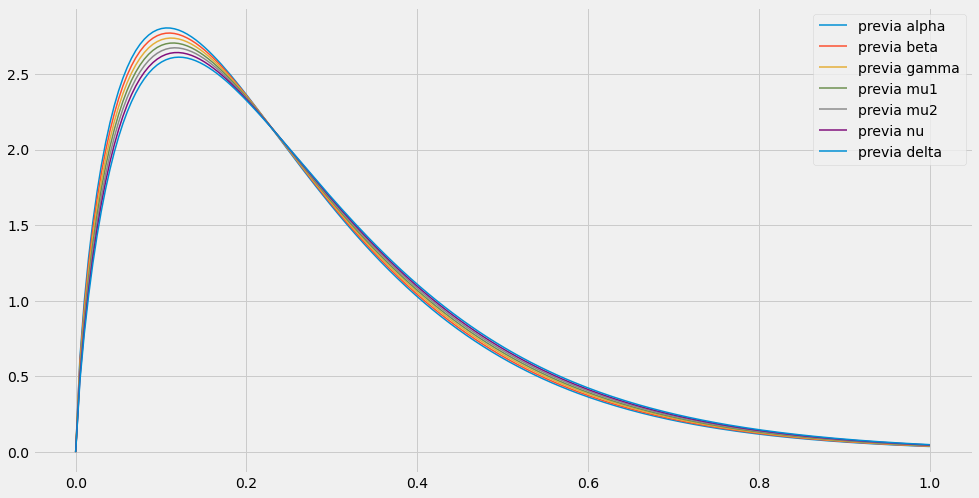

In [16]:
par1=[1.71,0,0.151]  #hiperparámetros para alpha
par2=[1.72,0,0.152]  #hiperparámetros para beta
par3=[1.73,0,0.153]  #hiperparámetros para gamma
par4=[1.74,0,0.154] #hiperparámetros para mu1
par5=[1.75,0,0.155] #hiperparámetros para mu2
par6=[1.76,0,0.156] #hiperparámetros para nu
par7=[1.77,0,0.157] #hiperparámetros para delta
x = np.linspace(0., 1., 200)
prev1 = scipy.stats.gamma.pdf(x, par1[0],par1[1],par1[2])
prev2 = scipy.stats.gamma.pdf(x, par2[0],par2[1],par2[2])
prev3 = scipy.stats.gamma.pdf(x, par3[0],par3[1],par3[2])
prev4 = scipy.stats.gamma.pdf(x, par4[0],par4[1],par4[2])
prev5 = scipy.stats.gamma.pdf(x, par5[0],par5[1],par5[2])
prev6 = scipy.stats.gamma.pdf(x, par6[0],par6[1],par6[2])
prev7 = scipy.stats.gamma.pdf(x, par7[0],par7[1],par7[2])


##Graficamos
pl.figure(figsize=(15, 8))
pl.plot(x, prev1, label='previa alpha',linewidth=1.5)
pl.plot(x, prev2,  label='previa beta',linewidth=1.5)
pl.plot(x, prev3,  label='previa gamma',linewidth=1.5)
pl.plot(x, prev4,  label='previa mu1',linewidth=1.5)
pl.plot(x, prev5,  label='previa mu2',linewidth=1.5)
pl.plot(x, prev6,  label='previa nu',linewidth=1.5)
pl.plot(x, prev7,  label='previa delta',linewidth=1.5)
pl.legend(loc="best")
pl.show()

In [17]:
def logverosimilitud(theta):
  n_sem1=15
  alpha,beta,gamma,mu1,mu2,nu,delta=theta.copy()
  t_dias=arange(0,7*n_sem1,1)
  modelo=integrate.odeint(ode_SID,INPUT,t_dias,args=(alpha,beta,gamma,mu1,mu2,nu,delta,))
  acum_dia=modelo[:,2]
  #Incidencia semanal
  inc_sem=incidencia(acum_dia,7)
  #Se están teniendo problemas con los ceros, así que se removerán
  vers=zeros((n_sem1))
  for i in range(0,n_sem1):
      if inc_sem[i]!=0 and data_sem[i]!=0: 
          vers[i]=-inc_sem[i]+data_sem[i]*log(abs(inc_sem[i]))
      elif inc_sem[i]!=0 and data_sem[i]==0:
          vers[i]=-inc_sem[i]
      #Si inc_sem[i]=0 la verosimilitud de ese dato es cero
  #Sumar porque es el logaritmo de la verosimilitud
  ver=float(sum(vers))
  #print(ver)
  return(ver) 

#### Posterior
def logposterior(theta):
  return(logaprioris(theta)+logverosimilitud(theta))

In [18]:
#Distribución posterior
def posterior(theta):
    #print("1",logaprioris(theta)+logverosimilitud(theta))
    return((exp(logaprioris(theta)+logverosimilitud(theta))))

In [19]:
# Genera las propuestas
def rkernelprop(present, sd, size=1):
    myclip_a = 0
    myclip_b = 1e10
    a, b = (myclip_a - present) / sd, (myclip_b - present) / sd
    proposal = truncnorm.rvs(a,b,loc = present, scale = sd, size=size)
    return(proposal)

# Reporta la densidad de la propuesta    
def dkernelprop(prop,present,sd):
    myclip_a = 0
    myclip_b = 1e10
    a, b = (myclip_a - present) /sd, (myclip_b - present) / sd
    denproposal = truncnorm.pdf(prop, a, b, loc = present, scale = sd)
    return(denproposal)

In [20]:
def inicializa():
  flag=False
  while flag==False:
    a = scipy.stats.gamma.rvs(par1[0],par1[1],par1[2])
    b = scipy.stats.gamma.rvs(par2[0],par2[1],par2[2])    
    c = scipy.stats.gamma.rvs(par3[0],par3[1],par3[2])
    d = scipy.stats.gamma.rvs(par4[0],par4[1],par4[2])
    e = scipy.stats.gamma.rvs(par5[0],par5[1],par5[2])
    f = scipy.stats.gamma.rvs(par6[0],par6[1],par6[2])
    g = scipy.stats.gamma.rvs(par7[0],par7[1],par7[2])
    tt = np.array([a, b, c, d, e,f,g])
    print("entra")
    if posterior(tt)>0:
      theta_ini = tt
      flag=True
  return(theta_ini)

In [21]:
par1=[2.5,0,0.15]  #hiperparámetros para alpha
par2=[1.1,0,0.16]  #hiperparámetros para beta
par3=[1.2,0,0.15]  #hiperparámetros para gamma
par4=[2.1,0,0.13] #hiperparámetros para mu1
par5=[2.1,0,0.2] #hiperparámetros para mu2
par6=[1.2,0,0.11] #hiperparámetros para nu
par7=[1.7,0,0.15] #hiperparámetros para delta


#Generando los valores iniciales
tt = inicializa()
tt

entra
entra


array([0.61483599, 0.04468373, 0.27548094, 0.12279234, 0.97320195,
       0.3276339 , 0.13510479])

In [22]:
def MH(iters, theta_ini, sd):
    theta_act = theta_ini

    alpha_v = np.zeros(iters)          ## guardar cadenas de alfas
    beta_v = np.zeros(iters)          ##guardar cadenas de betas
    gamma_v = np.zeros(iters)          ##guardar cadenas de gammas
    mu1_v = np.zeros(iters)            ##guardar cadenas de mu1s
    mu2_v = np.zeros(iters)             ##guardar cadenas de mu2s
    nu_v = np.zeros(iters)             ##guardar cadenas de nus
    delta_v = np.zeros(iters)          ##guardar cadenas de deltas
    logposter_v = np.empty(iters)   ##guardar todas las posteriores
    
    ### primer entrada de cada cadena
    logposter_v[0] = logposterior(theta_act)
    theta_prop = [0., 0. , 0.,0., 0. , 0.,0.]
    actualizo = 0

    for i in range(1,iters):
        ### empieza propuesta
        theta_prop[0] = rkernelprop(present = theta_act[0], sd = sd, size=1)[0]
        theta_prop[1] = rkernelprop(present = theta_act[1], sd = sd, size=1)[0]
        theta_prop[2] = rkernelprop(present = theta_act[2], sd = sd, size=1)[0]
        theta_prop[3] = rkernelprop(present = theta_act[3], sd = sd, size=1)[0]
        theta_prop[4] = rkernelprop(present = theta_act[4], sd = sd, size=1)[0]
        theta_prop[5] = rkernelprop(present = theta_act[5], sd = sd, size=1)[0]
        theta_prop[6] = rkernelprop(present = theta_act[6], sd = sd, size=1)[0]
        #print(theta_prop)

        # alfa
        qxy = dkernelprop(theta_act[0], theta_prop[0],sd) * dkernelprop(theta_act[1], theta_prop[1],sd) * dkernelprop(theta_act[2],theta_prop[2],sd) * dkernelprop(theta_act[3],theta_prop[3],sd)* dkernelprop(theta_act[4],theta_prop[4],sd)* dkernelprop(theta_act[5],theta_prop[5],sd)* dkernelprop(theta_act[6],theta_prop[6],sd) #centrada en propuesto
        qyx = dkernelprop(theta_prop[0],theta_act[0],sd) * dkernelprop(theta_prop[1],theta_act[1],sd) * dkernelprop(theta_prop[2],theta_act[2],sd) * dkernelprop(theta_prop[3],theta_act[3],sd)  * dkernelprop(theta_prop[4],theta_act[4],sd) * dkernelprop(theta_prop[5],theta_act[5],sd)* dkernelprop(theta_prop[6],theta_act[6],sd)#centrada en actual
    
        lognum = logposterior(theta_prop)+np.log(qxy)
        logden = logposterior(theta_act)+np.log(qyx)
        razon = np.exp(lognum - logden)
        A = min(1,razon)
        #print(A)
        #print(posterior(theta_prop), posterior(theta_act))

        if np.random.uniform(0,1,1)<A: # actualiza
          alpha_v[i] = theta_prop[0]
          beta_v[i] = theta_prop[1]   
          gamma_v[i] = theta_prop[2]
          mu1_v[i] = theta_prop[3]
          mu2_v[i] = theta_prop[4]
          nu_v[i] = theta_prop[5]
          delta_v[i] = theta_prop[6]
          logposter_v[i] = logposterior(theta_prop)
          theta_act = theta_prop.copy()
          actualizo += 1
        else: # no actualiza
          alpha_v[i] = theta_act[0]
          beta_v[i] = theta_act[1]   
          gamma_v[i] = theta_act[2]
          mu1_v[i] = theta_act[3]
          mu2_v[i] = theta_act[4]
          nu_v[i] = theta_act[5]
          delta_v[i] = theta_act[6]
          logposter_v[i] = logposterior(theta_act)

    rechazo = iters-actualizo        
    theta = np.array([alpha_v, beta_v, gamma_v,mu1_v,mu2_v,nu_v,delta_v])
    return(theta, logposter_v, rechazo, actualizo)

In [25]:
random.seed(2022) 
iters=10000
sims,logpost,rechazo,actualizo=MH(iters=iters,theta_ini=tt,sd=0.004)
%timeit sims
print('rechazó: ',rechazo)
print('actualizó: ',actualizo)

/usr/local/lib/python3.8/dist-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


32.5 ns ± 0.766 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
rechazó:  9076
actualizó:  924


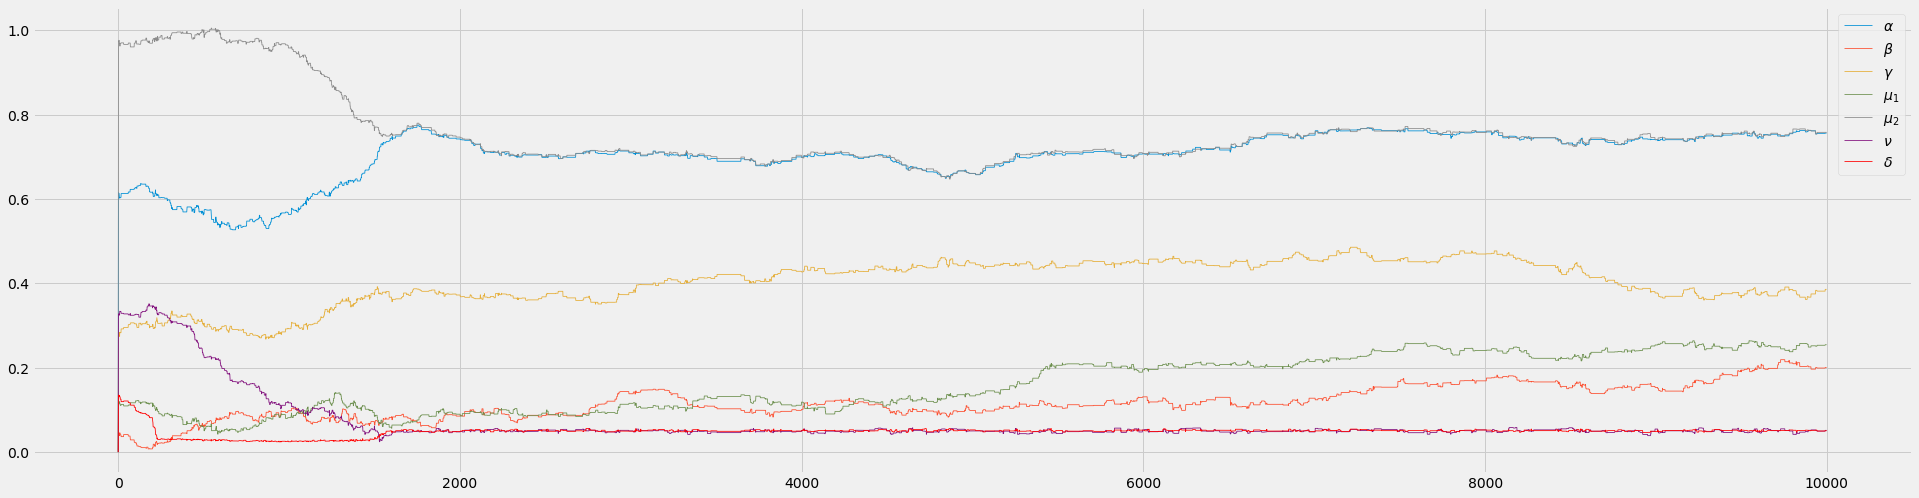

In [26]:
sims.shape
pl.figure(figsize=(30, 8))
pl.plot(sims[0,:], label=r'$\alpha$',linewidth=0.8)
pl.plot(sims[1,:],  label=r'$\beta$',linewidth=0.8)
pl.plot(sims[2,:],  label=r'$\gamma$',linewidth=0.8)
pl.plot(sims[3,:],  label=r'$\mu_1$',linewidth=0.8)
pl.plot(sims[4,:],  label=r'$\mu_2$',linewidth=0.8)
pl.plot(sims[5,:],  label=r'$\nu$',linewidth=0.8)
pl.plot(sims[6,:],  label=r'$\delta$',color='r',linewidth=0.8)
pl.legend(loc="best")
pl.show()

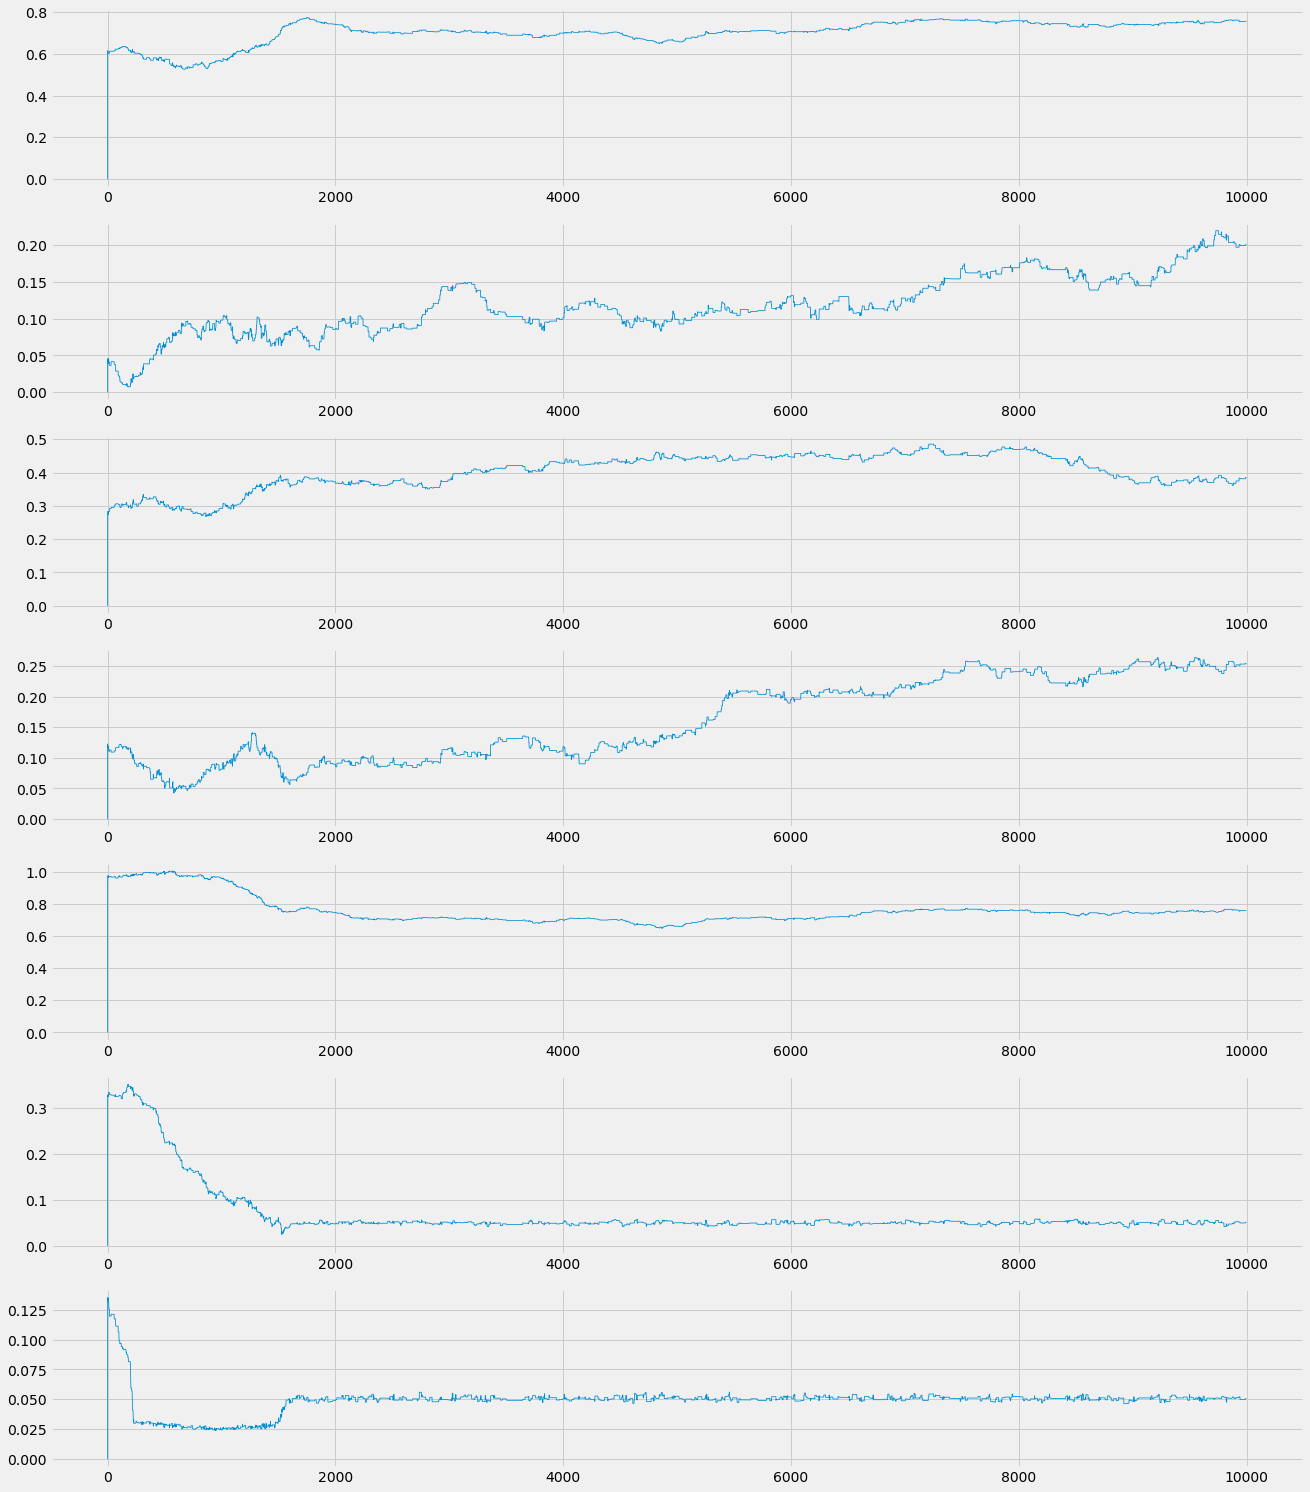

In [37]:
fig,ax=subplots(7,1,figsize=(20,25))
for i in range(7):
  ax[i].plot(sims[i,:],linewidth=0.8)

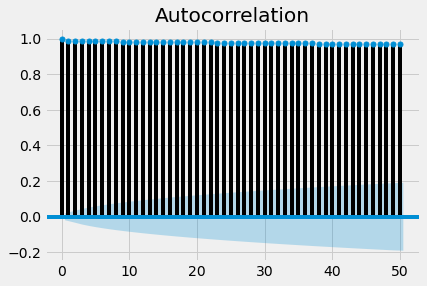

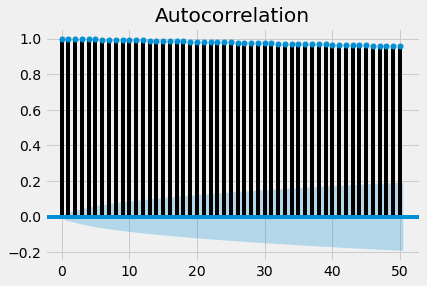

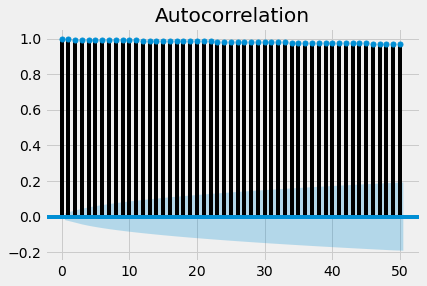

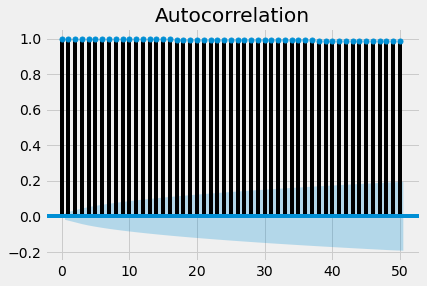

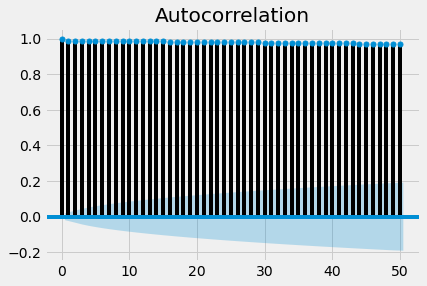

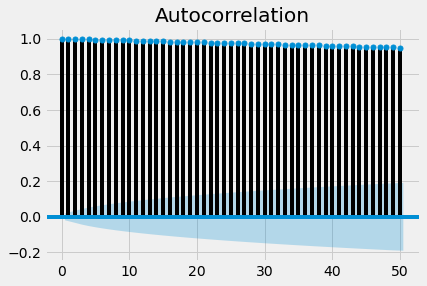

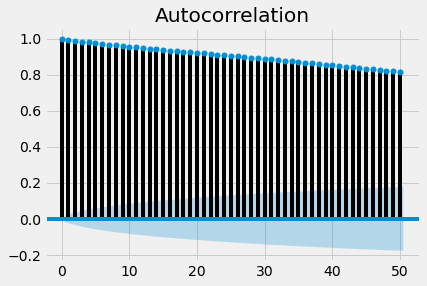

In [38]:
plot_acf(sims[0,:].tolist(),lags=50);
plot_acf(sims[1,:].tolist(),lags=50);
plot_acf(sims[2,:].tolist(),lags=50);
plot_acf(sims[3,:].tolist(),lags=50);
plot_acf(sims[4,:].tolist(),lags=50);
plot_acf(sims[5,:].tolist(),lags=50);
plot_acf(sims[6,:].tolist(),lags=50);

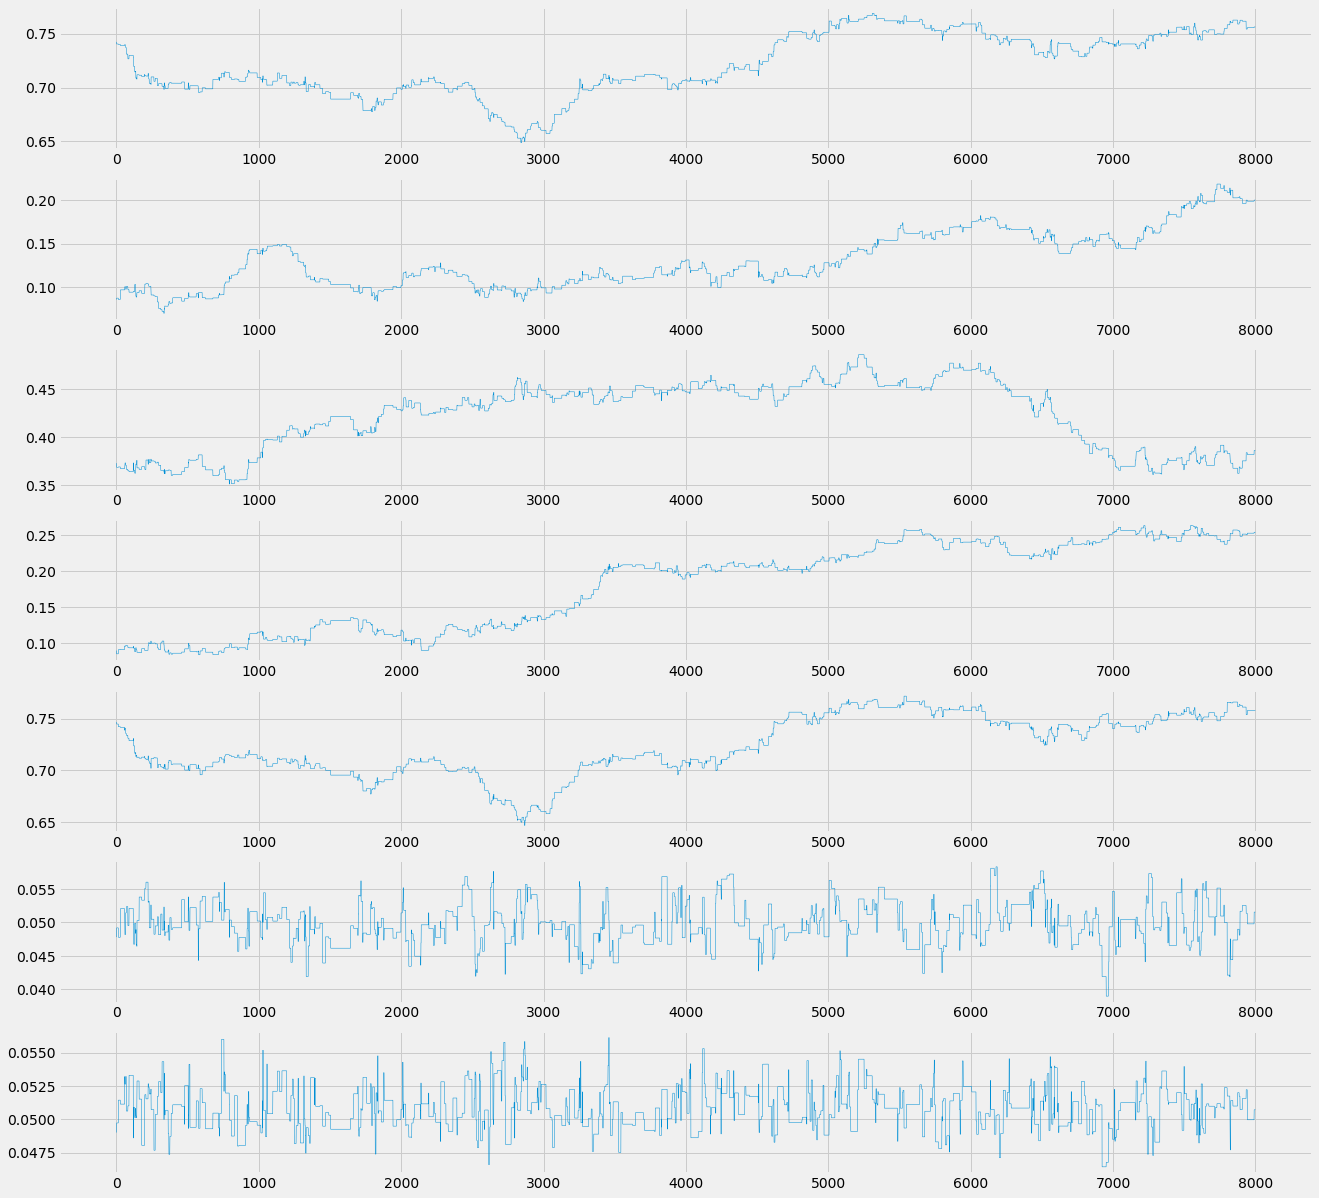

In [39]:
burnin=2000
fig=figure(figsize=(20,20)) 
ax1=subplot(7,1,1) 
ax1.plot(sims[0,burnin:iters],linewidth=0.5)
ax2=subplot(7,1,2)
ax2.plot(sims[1,burnin:iters],linewidth=0.5)
ax3=subplot(7,1,3)
ax3.plot(sims[2,burnin:iters],linewidth=0.5)
ax4=subplot(7,1,4)
ax4.plot(sims[3,burnin:iters],linewidth=0.5)
ax5=subplot(7,1,5)
ax5.plot(sims[4,burnin:iters],linewidth=0.5)
ax6=subplot(7,1,6)
ax6.plot(sims[5,burnin:iters],linewidth=0.5)
ax5=subplot(7,1,7)
ax5.plot(sims[6,burnin:iters],linewidth=0.5)
pl.show()

In [40]:
#Tamaño de muestra efectivo
def ess(data, stepSize=1):
    """ Effective sample size, as computed by BEAST Tracer."""
    samples=len(data)

    assert len(data)>1,"no stats for short sequences"
    maxLag=min(samples//3,1000)

    gammaStat=[0,]*maxLag
    varStat = 0.0;

    if type(data)!=ndarray:
        data=array(data)

    normalizedData=data-data.mean()

    for lag in range( maxLag ):
        v1=normalizedData[:samples - lag]
        v2=normalizedData[lag:]
        v=v1*v2
        gammaStat[lag]=sum(v)/len(v)
        if lag==0:
            varStat=gammaStat[0]
        elif lag%2==0:
            s=gammaStat[lag-1]+gammaStat[lag]
            if s>0:
                varStat+=2.0*s
            else:
                break

    #auto correlation time
    act=stepSize*varStat/gammaStat[0]
    # effective sample size
    ess=(stepSize*samples)/act
    return ess
    
def adelg_cadena(cad_param,saltos):
    n,m=shape(cad_param)
    m_new=int(m/saltos)
    #Matriz con las nuevas cadenas de los parámetros
    cad_new=zeros((n,m_new))
    for i in range(0,n):
        for j in range(0,m_new):
            cad_new[i,j]=cad_param[i,saltos*j]
    return cad_new

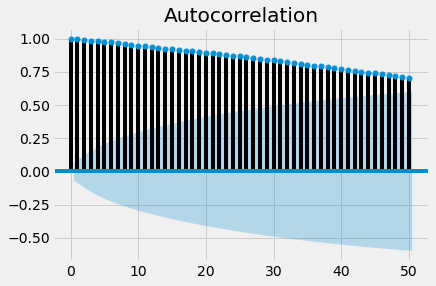

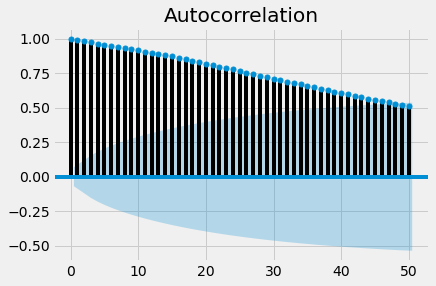

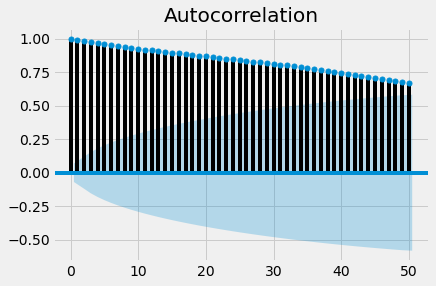

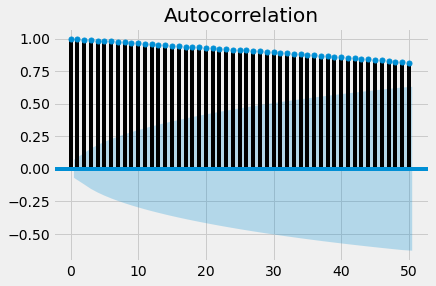

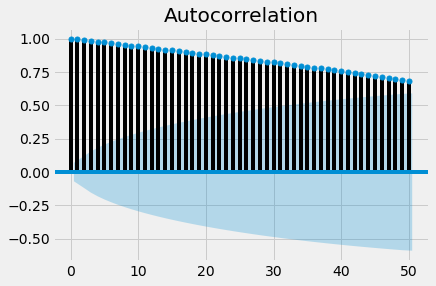

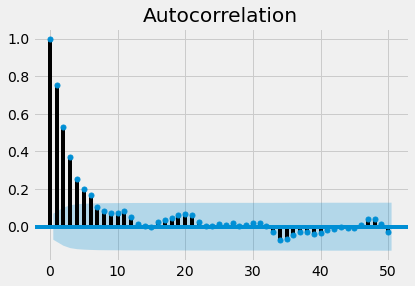

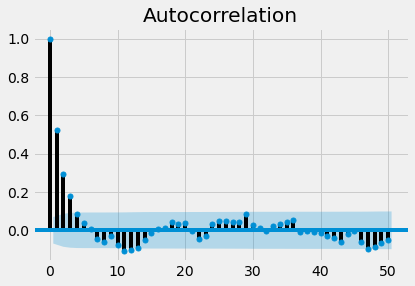

In [41]:
cad_adelg10=adelg_cadena(sims[:,burnin:iters],10)
#Graficar autocorrelaciones las cadenas adelgazadas
plot_acf(cad_adelg10[0,:].tolist(),lags=50);
plot_acf(cad_adelg10[1,:].tolist(),lags=50);
plot_acf(cad_adelg10[2,:].tolist(),lags=50);
plot_acf(cad_adelg10[3,:].tolist(),lags=50);
plot_acf(cad_adelg10[4,:].tolist(),lags=50);
plot_acf(cad_adelg10[5,:].tolist(),lags=50);
plot_acf(cad_adelg10[6,:].tolist(),lags=50);

In [42]:
salpha10=ess(cad_adelg10[0,:])
sbeta10=ess(cad_adelg10[1,:])
sgamma10=ess(cad_adelg10[2,:])
smu110=ess(cad_adelg10[3,:])
smu210=ess(cad_adelg10[4,:])
snu10=ess(cad_adelg10[5,:])
sdelta10=ess(cad_adelg10[6,:])
print("Tamaño de muestra efectivo para cada parámetro: ",[salpha10,sbeta10,sgamma10,smu110,smu210,snu10,sdelta10])

Tamaño de muestra efectivo para cada parámetro:  [3.31021369294375, 3.4374071610724926, 5.289700562692446, 2.459134930339498, 3.3556367228722337, 107.84870727076515, 245.6636147904486]


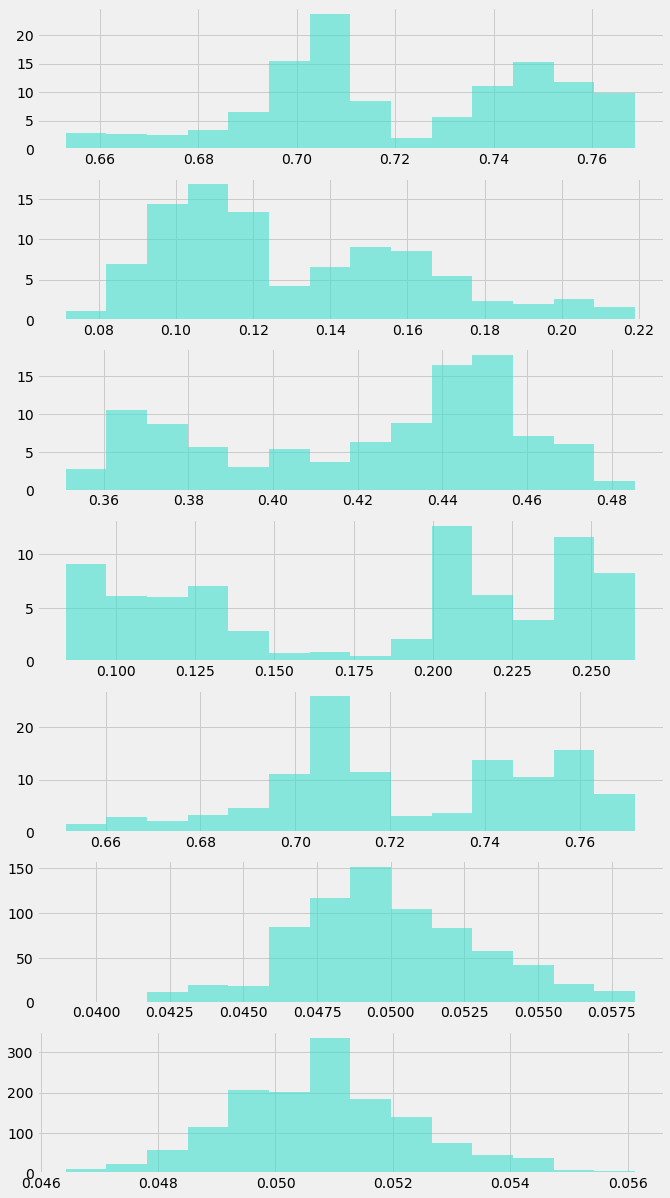

In [43]:
fig=figure(figsize=(10,20)) 

ax1=subplot(7,1,1)
hist(cad_adelg10[0,:],14,density=True,histtype='bar',color='turquoise',alpha=0.6);
          
ax2=subplot(7,1,2)
hist(cad_adelg10[1,:],14,density=True,histtype='bar',color ='turquoise',alpha=0.6);

ax3=subplot(7,1,3)
hist(cad_adelg10[2,:],14,density=True,histtype='bar',color='turquoise',alpha=0.6);

ax4=subplot(7,1,4)
hist(cad_adelg10[3,:],14,density=True,histtype='bar',color ='turquoise',alpha=0.6);

ax5=subplot(7,1,5)
hist(cad_adelg10[4,:],14,density=True,histtype='bar',color='turquoise',alpha=0.6);

ax6=subplot(7,1,6)
hist(cad_adelg10[5,:],14,density=True,histtype='bar',color='turquoise',alpha=0.6);

ax7=subplot(7,1,7)
hist(cad_adelg10[6,:],14,density=True,histtype='bar',color='turquoise',alpha=0.6);

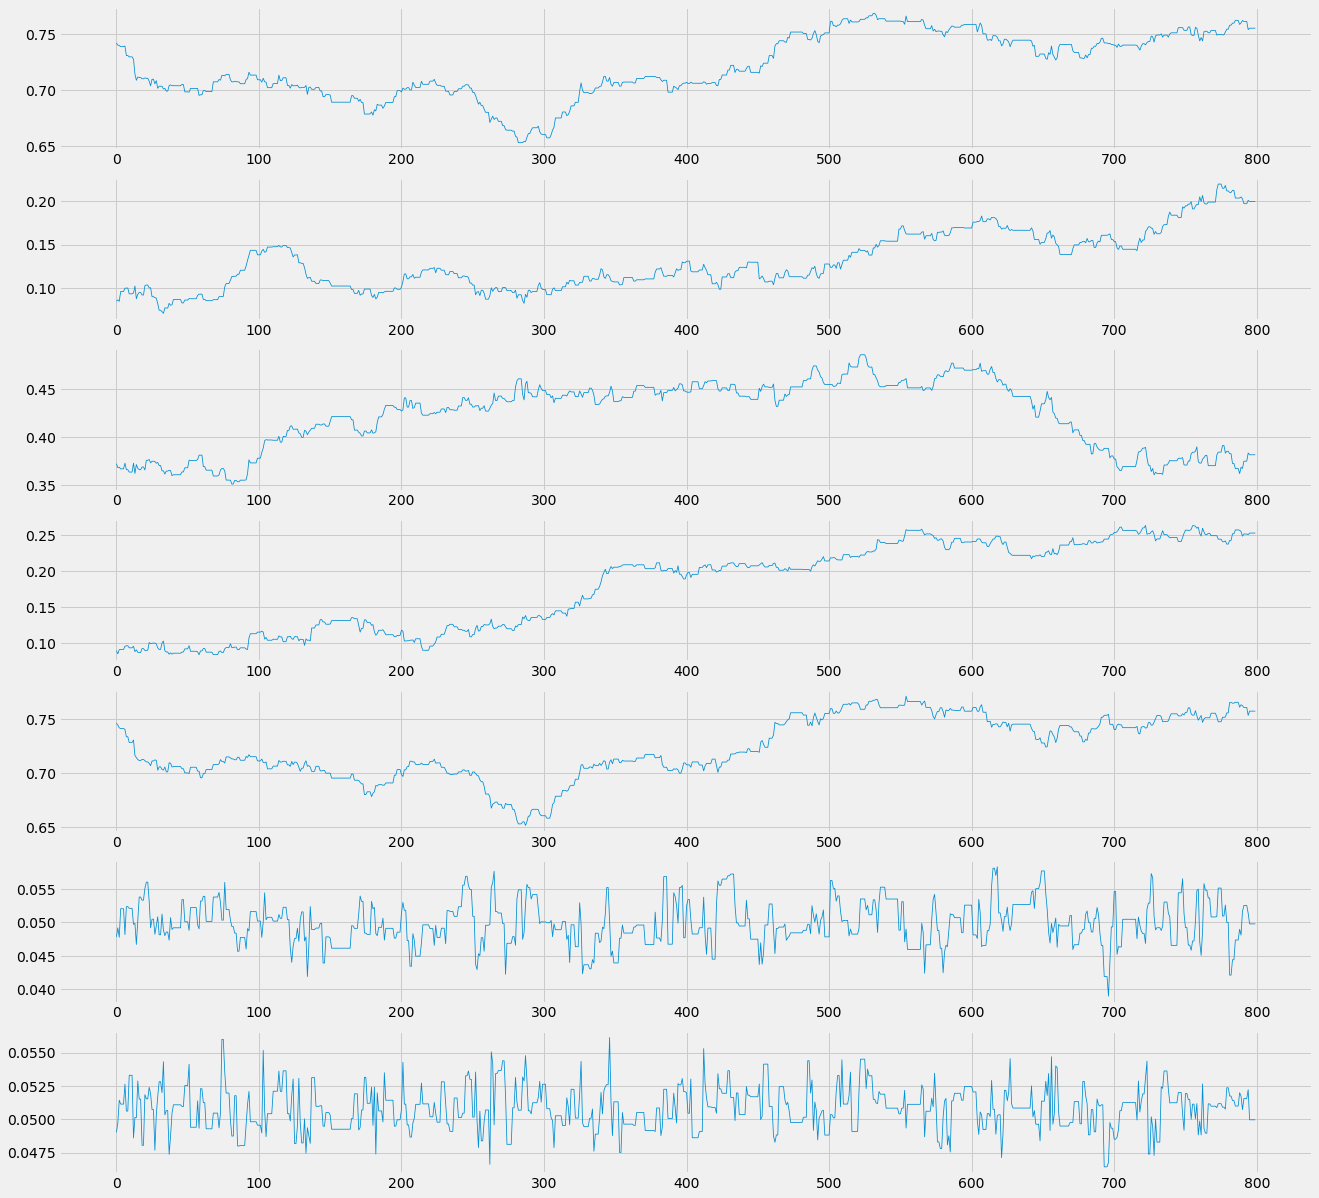

In [44]:
fig=figure(figsize=(20,20)) 
ax1=subplot(7,1,1) 
ax1.plot(cad_adelg10[0,:],linewidth=0.8)
ax2=subplot(7,1,2)
ax2.plot(cad_adelg10[1,:],linewidth=0.8)
ax3=subplot(7,1,3) 
ax3.plot(cad_adelg10[2,:],linewidth=0.8)
ax4=subplot(7,1,4)
ax4.plot(cad_adelg10[3,:],linewidth=0.8)
ax5=subplot(7,1,5)
ax5.plot(cad_adelg10[4,:],linewidth=0.8)
ax6=subplot(7,1,6)
ax6.plot(cad_adelg10[5,:],linewidth=0.8)
ax7=subplot(7,1,7)
ax7.plot(cad_adelg10[6,:],linewidth=0.8)
pl.show()

In [45]:
#Intervalo del 95% de densidad posterior
int_alpha=mquantiles(cad_adelg10[0,:],prob=[0.025,0.975])
int_beta=mquantiles(cad_adelg10[1,:],prob=[0.025,0.975])
int_gamma=mquantiles(cad_adelg10[2,:],prob=[0.025,0.975])
int_mu1=mquantiles(cad_adelg10[3,:],prob=[0.025,0.975])
int_mu2=mquantiles(cad_adelg10[4,:],prob=[0.025,0.975])
int_nu=mquantiles(cad_adelg10[5,:],prob=[0.025,0.975])
int_delta=mquantiles(cad_adelg10[6,:],prob=[0.025,0.975])
                 
print("Intervalo alpha: ",int_alpha)
print("Intervalo beta: ",int_beta)
print("Intervalo gamma: ",int_gamma)
print("Intervalo mu1",int_mu1)
print("Intervalo mu2",int_mu2)
print("Intervalo nu",int_nu)
print("Intervalo delta",int_delta)

Intervalo alpha:  [0.66305138 0.76341138]
Intervalo beta:  [0.08591033 0.20263471]
Intervalo gamma:  [0.36008591 0.47277406]
Intervalo mu1 [0.08762176 0.25720195]
Intervalo mu2 [0.66408232 0.76598554]
Intervalo nu [0.04367206 0.05660981]
Intervalo delta [0.04786491 0.05432613]


In [46]:
#Mediana
median_alpha=mquantiles(cad_adelg10[0,:],prob=[0.5])
median_beta=mquantiles(cad_adelg10[1,:],prob=[0.5])
median_gamma=mquantiles(cad_adelg10[2,:],prob=[0.5])
median_mu1=mquantiles(cad_adelg10[3,:],prob=[0.5])
median_mu2=mquantiles(cad_adelg10[4,:],prob=[0.5])
median_nu=mquantiles(cad_adelg10[5,:],prob=[0.5])
median_delta=mquantiles(cad_adelg10[6,:],prob=[0.5])
print("alpha: ",median_alpha)
print("beta: ",median_beta)
print("Gamma: ",median_gamma)
print("mu1: ",median_mu1)
print("mu2: ",median_mu2)
print("nu: ",median_nu)
print("delta: ",median_delta)

alpha:  [0.71328346]
beta:  [0.12065294]
Gamma:  [0.4334588]
mu1:  [0.20371823]
mu2:  [0.71521188]
nu:  [0.04960129]
delta:  [0.0508348]


In [47]:
#Media
media_alpha=mean(cad_adelg10[0,:])
media_beta=mean(cad_adelg10[1,:])
media_gamma=mean(cad_adelg10[2,:])
media_mu1=mean(cad_adelg10[3,:])
media_mu2=mean(cad_adelg10[4,:])
media_nu=mean(cad_adelg10[5,:])
media_delta=mean(cad_adelg10[6,:])
print("alpha: ",media_alpha)
print("beta: ",media_beta)
print("Gamma: ",media_gamma)
print("mu1: ",media_mu1)
print("mu2: ",media_mu2)
print("nu: ",media_nu)
print("delta: ",media_delta)

alpha:  0.7210422349700163
beta:  0.13012168164817514
Gamma:  0.42184355473545077
mu1:  0.18019131276277167
mu2:  0.7234727975423831
nu:  0.0499068615684943
delta:  0.050824759062670734


In [48]:
#Moda
moda_alpha=max(cad_adelg10[0,:])
moda_beta=max(cad_adelg10[1,:])
moda_gamma=max(cad_adelg10[2,:])
moda_mu1=max(cad_adelg10[3,:])
moda_mu2=max(cad_adelg10[4,:])
moda_nu=max(cad_adelg10[5,:])
moda_delta=max(cad_adelg10[6,:])

print("alpha: ",moda_alpha)
print("beta: ",moda_beta)
print("Gamma: ",moda_gamma)
print("mu1: ",moda_mu1)
print("mu2: ",moda_mu2)
print("nu: ",moda_nu)
print("delta: ",moda_delta)

alpha:  0.7687227233573364
beta:  0.21900686825948734
Gamma:  0.4855080816515308
mu1:  0.2637924982894137
mu2:  0.7716787152075864
nu:  0.05829624403948598
delta:  0.05612466779469371


In [49]:
model_median=integrate.odeint(ode_SID,INPUT,t_range,args=(median_alpha[0],median_beta[0],median_gamma[0],median_mu1[0],median_mu2[0],median_nu[0],median_delta[0],))
Y_acum_median=model_median[:,3]
inc_median=incidencia(Y_acum_median,7)


model_media=integrate.odeint(ode_SID,INPUT,t_range,args=(media_alpha,media_beta,media_gamma,median_mu1,media_mu2,median_nu,median_delta,))
Y_acum_media=model_media[:,3]
inc_media=incidencia(Y_acum_media,7)

model_moda=integrate.odeint(ode_SID,INPUT,t_range,args=(moda_alpha,moda_beta,moda_gamma,moda_mu1,moda_mu2,moda_nu,moda_delta,))
Y_acum_moda=model_moda[:,3]
inc_moda=incidencia(Y_acum_moda,7)

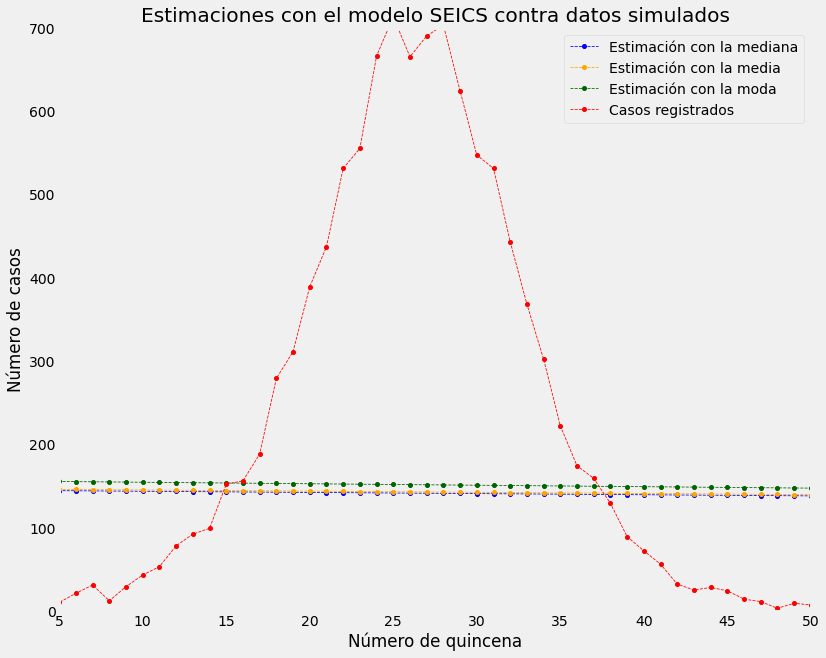

In [53]:
#Graficar el modelo obtenido con los datos estimados contra los datos registrados
pl.figure(figsize=(12,10))
pl.plot(t_sem,inc_median,linestyle="--",marker="o",markersize=4,linewidth=0.8,color='blue',label="Estimación con la mediana")
pl.plot(t_sem,inc_media,linestyle="--",marker="o",markersize=4,linewidth=0.8,color='orange',label="Estimación con la media")
pl.plot(t_sem,inc_moda,linestyle="--",marker="o",markersize=4,linewidth=0.8,color='darkgreen',label="Estimación con la moda")
pl.plot(t_sem,data_sem,linestyle="--",marker="o",markersize=4,linewidth=0.8,color='red',label="Casos registrados")
pl.ylabel("Número de casos")
pl.xlabel("Semana")
pl.legend()
pl.title("Estimaciones con el modelo SEICS contra datos simulados")
pl.grid()
pl.xlim([5,50])
pl.ylim([0,700])
pl.show()